In [424]:
import pandas as pd
import numpy as np
from scipy.stats import spearmanr
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.colors as colors

## Input data

In [425]:
clones_file = "cdr3-clones-AB-ADA-IGH_HUMAN-after-reassignment.csv" # 3MB file (run28)
pt_file = "20180514_Run028_pt-table_CORRECT.csv"
plotfile = "run28-AB-ADA-IGH_HUMAN.pdf"

#clones_file = "cdr3-clones-Eomes-TRB_MOUSE-after-reassignment.csv"  # 14 MB (run28)
#pt_file = "20180514_Run028_pt-table_CORRECT.csv"
#plotfile = "run28-Eomes-TRB_MOUSE.pdf"

#clones_file = "cdr3-clones-Prairi-IGH_HUMAN-after-reassignment.csv" # 22 MB (run25)
#pt_file = "20180326_RUN25_pt.table.csv"
#plotfile = "run25-Prairi-IGH_HUMAN.pdf"

#clones_file = "cdr3-clones-AB-RBF-TRB_HUMAN-after-reassignment.csv" # 300 MB file (run25)
#pt_file = "20180326_RUN25_pt.table.csv"
#plotfile = "run25-AB-RBF-TRB_HUMAN.pdf"

## Import clonesdata

In [426]:
clones = pd.read_csv(clones_file, sep="\t")
clones = clones.set_index('Sample')

In [427]:
clones.head()

,MID,cdr3pep,freq,uniq_umis,V_sub,J_sub,sum_sites,avg_sites,read_perc,umi_perc
Sample,,,,,,,,,,
AB-ADA37-Bu_S113,ACTGACTG,CARDTSLVDNAMIMGQGTLVT,9,9,IGHV3-11+IGHV3-48,"IGHJ5,IGHJ4",0,0.0,0.235048,0.238221
AB-ADA37-Bu_S113,ACTGACTG,CARSFSSSHFNYWGQGTLVT,8,8,IGHV6-1,IGHJ4,0,0.0,0.208932,0.211752
AB-ADA37-Bu_S113,ACTGACTG,CVRDSGPARPGFGMDVWGQGTTVT,7,7,IGHV3-21+IGHV3-30+IGHV3-48+IGHV3-66,IGHJ6,0,0.0,0.182815,0.185283
AB-ADA37-Bu_S113,ACTGACTG,CVRDSGPARPGYVMDVWGQGTTVT,7,7,IGHV3-21,IGHJ6,0,0.0,0.182815,0.185283
AB-ADA37-Bu_S113,ACTGACTG,CAKLAVAGGGYYHYYMDVWGKGTTVT,6,6,IGHV5-51,IGHJ6,0,0.0,0.156699,0.158814


## Import patient table

In [428]:
pt = pd.read_csv(pt_file, sep=";")

In [429]:
# Concatenate sample-id and nr in a new column
f = lambda x,y: str(x) + "_" + str(y)
pt['SampleNameNr'] = [name for name in map(f, pt['Sample name'], pt['Samples order'])]
pt = pt.set_index('SampleNameNr')
pt = pt["Patient"]

In [430]:
pt.head()

SampleNameNr
BMC101-1-BuH_S1    7839192
BMC101-2-BuH_S2    7839192
BMC102-1-BuH_S3    3836360
BMC102-2-BuH_S4    3836360
BMC103-1-BuH_S5    6824962
Name: Patient, dtype: object

## Merge clones with pt

In [431]:
pt.index[0:10]

Index(['BMC101-1-BuH_S1', 'BMC101-2-BuH_S2', 'BMC102-1-BuH_S3',
       'BMC102-2-BuH_S4', 'BMC103-1-BuH_S5', 'BMC103-2-BuH_S6',
       'BMC104-1-BuH_S7', 'BMC104-2-BuH_S8', 'Eomes-01_S9', 'Eomes-02_S10'],
      dtype='object', name='SampleNameNr')

In [432]:
# Join data frames
df = clones.join(pt)
df['SampleNameNr'] = df.index
df = df.set_index(['Patient', 'SampleNameNr'])
df.head()

MID                     cdr3pep  freq  \
Patient    SampleNameNr                                                   
40-01-0013 AB-ADA37-Bu_S113  ACTGACTG       CARDTSLVDNAMIMGQGTLVT     9   
           AB-ADA37-Bu_S113  ACTGACTG        CARSFSSSHFNYWGQGTLVT     8   
           AB-ADA37-Bu_S113  ACTGACTG    CVRDSGPARPGFGMDVWGQGTTVT     7   
           AB-ADA37-Bu_S113  ACTGACTG    CVRDSGPARPGYVMDVWGQGTTVT     7   
           AB-ADA37-Bu_S113  ACTGACTG  CAKLAVAGGGYYHYYMDVWGKGTTVT     6   

                             uniq_umis                                V_sub  \
Patient    SampleNameNr                                                       
40-01-0013 AB-ADA37-Bu_S113          9                    IGHV3-11+IGHV3-48   
           AB-ADA37-Bu_S113          8                              IGHV6-1   
           AB-ADA37-Bu_S113          7  IGHV3-21+IGHV3-30+IGHV3-48+IGHV3-66   
           AB-ADA37-Bu_S113          7                             IGHV3-21   
           AB-ADA37-Bu_S113          6                             IGHV5-51   

                                   J_sub  sum_sites  avg_sites  read_perc  \
Patient    SampleNameNr                                                     
40-01-0013 AB-ADA37-Bu_S113  IGHJ5,IGHJ4          0        0.0   0.235048   
           AB-ADA37-Bu_S113        IGHJ4          0        0.0   0.208932   
           AB-ADA37-Bu_S113        IGHJ6          0        0.0   0.182815   
           AB-ADA37-Bu_S113        IGHJ6          0        0.0   0.182815   
           AB-ADA37-Bu_S113        IGHJ6          0        0.0   0.156699   

                             umi_perc  
Patient    SampleNameNr                
40-01-0013 AB-ADA37-Bu_S113  0.238221  
           AB-ADA37-Bu_S113  0.211752  
           AB-ADA37-Bu_S113  0.185283  
           AB-ADA37-Bu_S113  0.185283  
           AB-ADA37-Bu_S113  0.158814

## Count overlapping clones between samples

In [433]:
# Sort index for better performance
df = df.sort_index()

# Make empty data frame for the distance matrix
colnames = list(set(df.index))
colnames.sort()
overlap = pd.DataFrame(index=colnames, columns=colnames, dtype=np.float)

In [434]:
# Function to count overlapping elements (cdr3pep): Jaccard index
dist = lambda x, y: len(set(x).intersection(set(y))) / len(set(x).union(set(y)))

for x in overlap.index:
    for y in overlap.index:
        overlap[x][y] = max(dist(df.loc[x]['cdr3pep'], df.loc[y]['cdr3pep']), 0.0000000001) # Jaccard

In [435]:
overlap.head()

,"(40-01-0013, AB-ADA37-Bu_S113)","(40-01-0017, AB-ADA84-Bu_S114)"
"(40-01-0013, AB-ADA37-Bu_S113)",1.000000,0.000101
"(40-01-0017, AB-ADA84-Bu_S114)",0.000101,1.000000


In [436]:
# Replace NaN and zero's with low number
overlap[overlap.isna()] = 0.0000000001
overlap[overlap == 0] = 0.0000000001

## Create a heatmap

Wrote run28-AB-ADA-IGH_HUMAN.pdf to disk


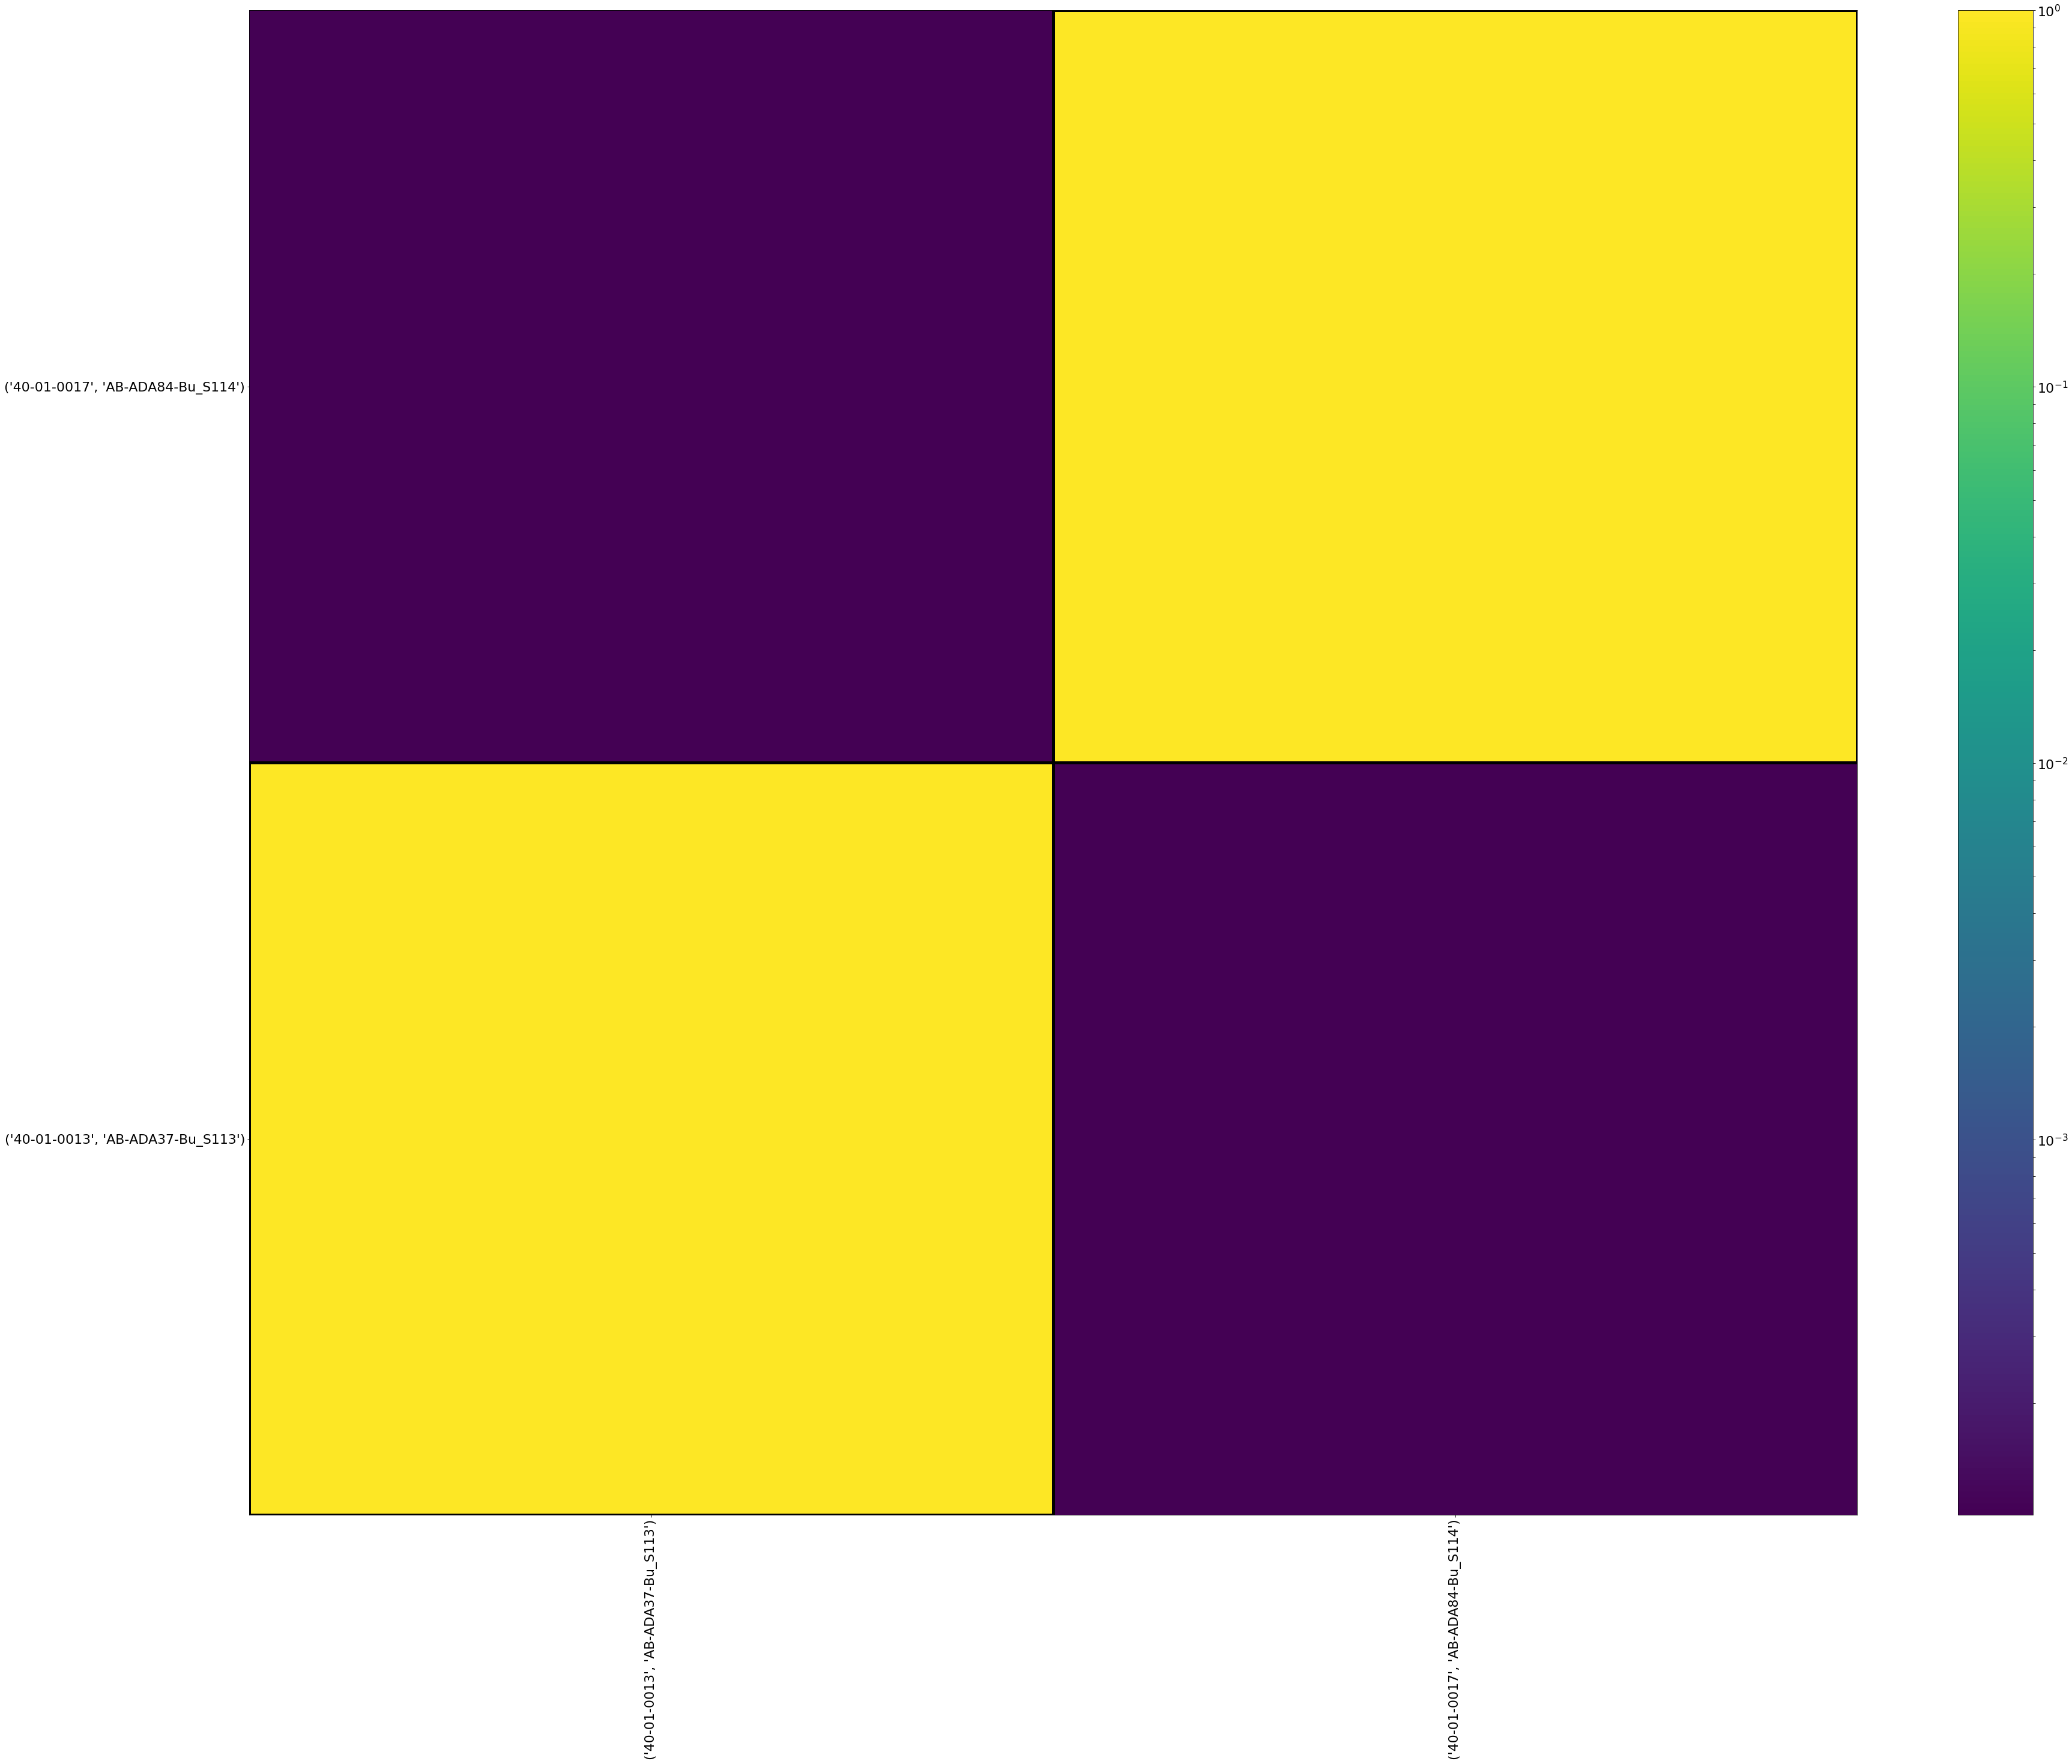

In [437]:
font = {'family' : 'sans-serif',
        'weight' : 'normal',
        'size'   : 22}

matplotlib.rc('font', **font)

fig, ax = plt.subplots(figsize=(60, 60))
fig.subplots_adjust(bottom=0.3)

# is used for log scaling
Z1 = overlap.values

# get the patient-id
labels_x = [x[0] for x in overlap.index]
labels_y = [y[0] for y in overlap.columns]

# draw heatmap
plt.pcolor(overlap.values, cmap=plt.cm.viridis, norm=colors.LogNorm(vmin=Z1.min(), vmax=Z1.max()))
plt.colorbar()
plt.yticks(np.arange(0.5, len(overlap.index), 1), overlap.columns, rotation=0)
plt.xticks(np.arange(0.5, len(overlap.columns), 1), overlap.index, rotation=90)

# Add lines around same patient-id
def drawBox(end, length):
    '''
    Description: draw a square with lines
    In: start (int), length (int)
    Out: None, 4 lines will be drawn on the canvas
    '''
    linewidth = 5
    low = end - length
    high = end
    plt.plot([low, high], [high, high], 'k-', lw=linewidth)   # N
    plt.plot([high, high], [low, high], 'k-', lw=linewidth)   # E
    plt.plot([low, high], [low, low], 'k-', lw=linewidth)     # S
    plt.plot([low, low], [low, high], 'k-', lw=linewidth)     # W

prev_label = None
length = 0
for i in range(len(labels_x)):
    if prev_label is not None and prev_label != labels_x[i]:
        drawBox(i, length)
        length = 0
    prev_label = labels_x[i]
    length +=1
i += 1
drawBox(i, length)

# Save figure to file
fig.savefig(plotfile)
print("Wrote", plotfile, "to disk")